## $\color{SkyBlue}{\text{Weather Analysis}}$
#### $\color{SkyBlue}{\text{Roman Lynch}}$


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

$\rule{27cm}{0.4pt}$
### K-Means Algorithm

In [29]:
#--------------------------------------------------------------------------------#
def dist(x1, x2):
    return np.sqrt(np.sum(x1-x2)**2)
#--------------------------------------------------------------------------------#

In [30]:
#--------------------------------------------------------------------------------#
def kMeans(df, k, tol=0.0005): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    #---------------------------------------#
    #-- Initialize --#
    clusters = np.zeros(len(df))

    #-- k-means ++ --#
    centroids = []
    for i in range(k):
        # To intialize the centroids, we pick k datapoints (reliviley) evenly spaced from 
        # one another by Rank (due to rounding) #
        data_point_rank_k = df[df['Rank'] == np.round((i+1)*(15/k), 0)]
        centroids.append(data_point_rank_k.values[0])
    centroids = np.vstack(centroids)
    print(centroids)
    #----------------#
    
    mean_error = np.inf
    converged = False
    
    num_iterations = 0
    
    #---------------------------------------#
    #-- LOOP UNTIL CONVERGENCE --#
    while not(converged):
        
        #-- Cluster Assignment --#
        for index, data in enumerate(df.values):
            distances = [dist(data, centroid) for centroid in centroids]
            clusters[index] = np.argmin(distances)
        
        #-- Update Centroids --#
        updated_centroids = np.empty((k, df.shape[1]))
        for index in range(k):
            clust_data = df[clusters == index]
            centroid = clust_data.mean(axis=0)
            updated_centroids[index, :] = centroid
            
        #-- Calculate Meanerror --#
        errors = []
        for data, cluster in zip(df.values, clusters):
            centroid = updated_centroids[int(cluster)]
            errors.append(dist(data, centroid)**2)
        
        error_arr = np.array(errors)
        
        #-- Calculate Reconstruction Error --#
        rec_err = np.sum(error_arr)/len(df)
        
        #-- Check for Convergence --#
        if (abs(rec_err - mean_error) < tol):
            converged = True
#             print('Converged at iteration {} with a change of {}'.format(num_iterations, abs(rec_err - mean_error)))
        
        # Update Values
        centroids = updated_centroids
        mean_error = rec_err
        num_iterations = num_iterations + 1
        
    #---------------------------------------#
    return centroids, clusters, mean_error
#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### Dataframe Composition

In [31]:
#--------------------------------------------------------------------------------#
# Creating the master data frame

## Read in CSV files
df_weather = pd.read_csv("data/city_temperature.csv")
df_rankings = pd.read_csv("data/rankings.csv")
df_teams = pd.read_csv("data/team.csv")

## Only take important columns
df_weather = df_weather[['City', 'Year', 'AvgTemperature']]
df_rankings = df_rankings[['Team', 'Rank', 'Year']]
df_teams = df_teams[['full_name', 'abbreviation', 'city']]

## Clean "*" from all teams in df_rankings
for i in range(len(df_rankings)):
    if (df_rankings["Team"].iloc[i].find('*')):
        df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')

## Look onyl at cities in the nba
nba_cities = list(df_teams['city'].unique())

## Find wether data of nba_citites
df_weather = df_weather[df_weather['City'].isin(nba_cities)]

## Average the temperatures for each year and city such that there is only one instance of each city per year
df_weather = df_weather.groupby(['City', 'Year'])['AvgTemperature'].mean().reset_index()

## Create the master dataframe by including wether, city, team, and rank
df_merged = pd.merge(df_rankings,df_teams, left_on="Team", right_on="full_name")
df_master = pd.merge(df_weather, df_merged, left_on=['City', 'Year'], right_on=['city', 'Year'])
#--------------------------------------------------------------------------------#

print(df_master.head(5))



      City  Year  AvgTemperature           Team  Rank      full_name  \
0  Atlanta  2016       65.205738  Atlanta Hawks     5  Atlanta Hawks   
1  Atlanta  2017       64.850959  Atlanta Hawks     5  Atlanta Hawks   
2  Atlanta  2018       63.807123  Atlanta Hawks    15  Atlanta Hawks   
3  Atlanta  2019       65.569041  Atlanta Hawks    12  Atlanta Hawks   
4  Atlanta  2020       56.061940  Atlanta Hawks    14  Atlanta Hawks   

  abbreviation     city  
0          ATL  Atlanta  
1          ATL  Atlanta  
2          ATL  Atlanta  
3          ATL  Atlanta  
4          ATL  Atlanta  


In [32]:
#--------------------------------------------------------------------------------#
# Break the data up by year
df_16 = df_master[df_master["Year"] == 2016]
df_17 = df_master[df_master["Year"] == 2017]
df_18 = df_master[df_master["Year"] == 2018]
df_19 = df_master[df_master["Year"] == 2019]
df_20 = df_master[df_master["Year"] == 2020]
df_21 = df_master[df_master["Year"] == 2021]
df_22 = df_master[df_master["Year"] == 2022]

print(df_16.shape[0])
print(df_17.shape[0])
print(df_18.shape[0])
print(df_19.shape[0])
print(df_20.shape[0])

# No wether data for 2021 and 2022
print(df_21.shape[0])
print(df_22.shape[0])
#--------------------------------------------------------------------------------#

21
21
21
21
21
0
0


$\rule{27cm}{0.4pt}$ 
### Perform K-means with k = 3

In [33]:
#--------------------------------------------------------------------------------#
## Use k-Means for clustering withk = 3
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "AvgTemperature"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "AvgTemperature"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "AvgTemperature"]], k=3)
centroids_17, clusters_17, mean_error_17 = kMeans(df_17[["Rank", "AvgTemperature"]], k=3)
centroids_16, clusters_16, mean_error_16 = kMeans(df_16[["Rank", "AvgTemperature"]], k=3)
#--------------------------------------------------------------------------------#

[[ 5.         65.04626866]
 [10.         54.49701493]
 [15.         40.68208955]]


IndexError: index 0 is out of bounds for axis 0 with size 0

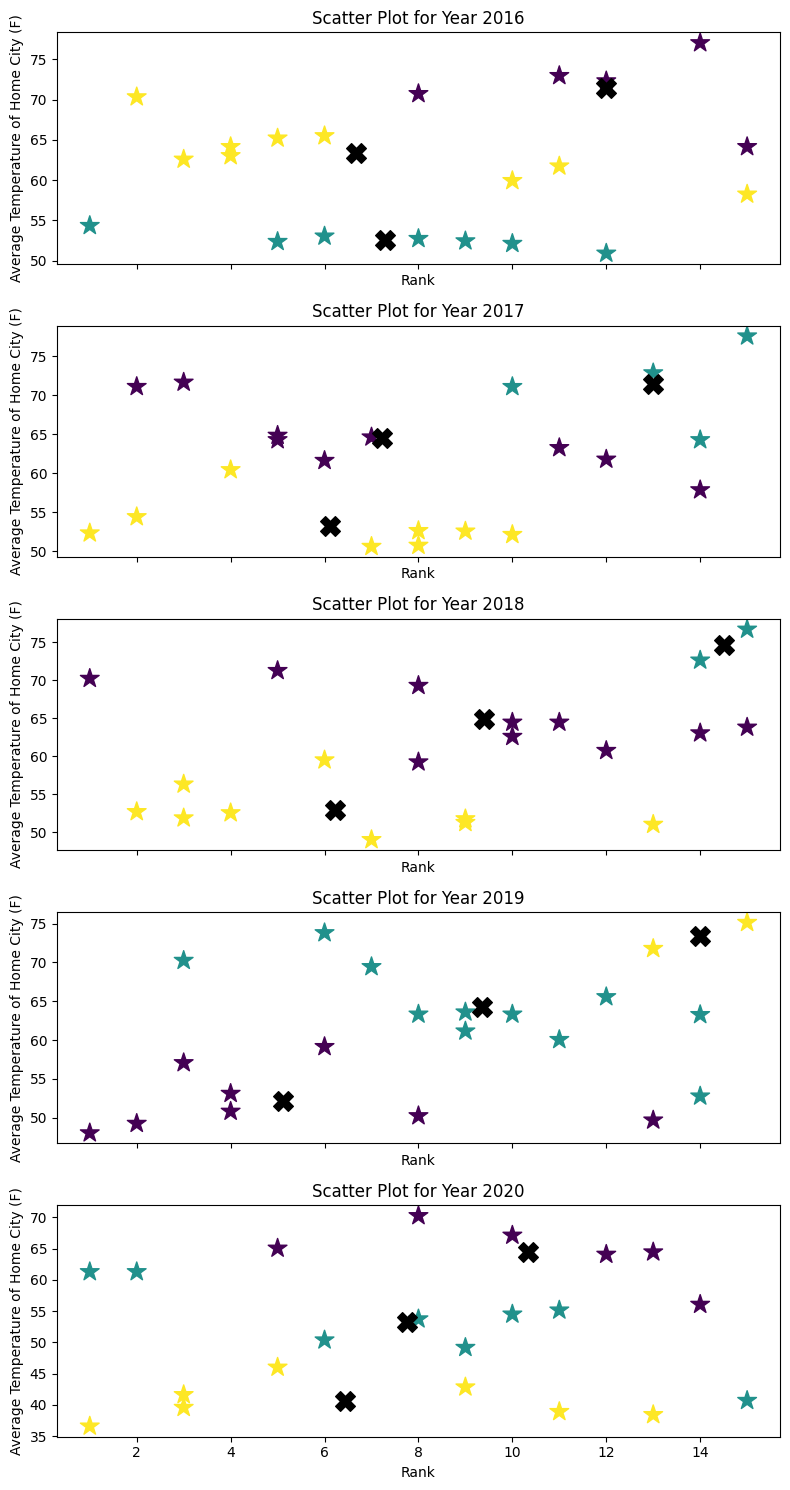

In [ ]:
#--------------------------------------------------------------------------------#
# Organize output
dataframes = [df_16, df_17, df_18, df_19, df_20]
clusters = [clusters_16, clusters_17, clusters_18, clusters_19, clusters_20]
years = [2016, 2017, 2018, 2019, 2020, 2021]
centroids = [centroids_16, centroids_17, centroids_18,centroids_19,centroids_20]
#--------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------#
# Plot the data

## Initialize Plot
fig, axes = plt.subplots(5, 1, figsize=(8, 15), sharex=True)

## Loop: Scatter Plot for each Year
for i, (year, dataframe, cluster) in enumerate(zip(years, dataframes, clusters)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['AvgTemperature'], c=cluster, marker='*', s=200)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Average Temperature of Home City (F)")
    ax.set_title("Scatter Plot for Year " + str(year))
    ## Plot centroids
    ax.scatter(centroids[i][:, 0], centroids[i][:, 1], marker='X', s=200, c='black')

plt.tight_layout()
plt.show()

plt.show()
#--------------------------------------------------------------------------------#

In [ ]:
max_temp_index = df_16['AvgTemperature'].idxmax()
city_with_max_temp_16 = df_16.loc[max_temp_index, 'City']

max_temp_index = df_17['AvgTemperature'].idxmax()
city_with_max_temp_17 = df_17.loc[max_temp_index, 'City']

max_temp_index = df_18['AvgTemperature'].idxmax()
city_with_max_temp_18 = df_18.loc[max_temp_index, 'City']

max_temp_index = df_19['AvgTemperature'].idxmax()
city_with_max_temp_19 = df_19.loc[max_temp_index, 'City']

max_temp_index = df_20['AvgTemperature'].idxmax()
city_with_max_temp_20 = df_20.loc[max_temp_index, 'City']

print("City with maximum Temperature in 2016:", city_with_max_temp_16)
print("City with maximum Temperature in 2017:", city_with_max_temp_17)
print("City with maximum Temperature in 2018:", city_with_max_temp_18)
print("City with maximum Temperature in 2019:", city_with_max_temp_19)
print("City with maximum Temperature in 2020:", city_with_max_temp_20)

City with maximum Temperature in 2016: Phoenix
City with maximum Temperature in 2017: Phoenix
City with maximum Temperature in 2018: Phoenix
City with maximum Temperature in 2019: Phoenix
City with maximum Temperature in 2020: Orlando


$\rule{27cm}{0.4pt}$ 
### Analysis

As evident by the above scatterplots, there does not appear to be a correlation between the final rank of an NBA team, and the weather of their home city.

Our origional hypothesis, was that athletes would be attracted to places with better climates. If this were to be the case, we would see three clusters:
1. High rank, medium temperature
2. Low rank, high temperature
3. Low rank, low temperature

Instead, we see a massive spread across the board with no real trend across any of the seasons. As a result, we can conclude that there is likely no correlation between the final rank of an NBA team, and the weather of their home city.